In [187]:
%pylab inline
import geopandas as gpd
import attr # using attr here to create a commodity class for horizon-related data storage
from smalllib import of, ff

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['size', 'normal']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


we will explore several methods to obtain 3D models representing the subsurface starting from the simpler techniques.
The problem is pretty simple in this case and can be tackled completely without commercial software.
We will perform an "analytical" modeling of the surfaces, in this case as flat planes, we do not have many constrints so flat planes might be a good first order approximation

In [188]:
# we load the horizons
hfile = of("horizons.gpkg")

horizons = []
for i in np.arange(3):
    h = gpd.read_file(hfile, layer=f"{str(i)}")
    horizons.append(h)

In [189]:
import rasterio
rdem = rasterio.open(of("cropped_dem_up.tif"))

In [190]:
p_0 = np.loadtxt(of("center_coords.txt")) # local center
region = np.loadtxt(of("region.txt")) #the region we are going to be inerested in

xmi, ymi, xma, yma = region
boundary_points = np.array([[xmi, ymi],
                            [xma, ymi],
                            [xma, yma],
                            [xmi, yma]]) - p_0[:2]

In [191]:
# we do some preprocessing to rearrange our input data, using a commodity Horizon class:
# this is a good practice for storing complex datasets. We would like to introduce as an example,
# it is not totally needed here but shows how using a data class with dedicated methods is useful

@attr.attrs
class Horizon():
    points = attr.ib() # points of this horizon
    hid = attr.ib() # the unique id of the horizon
    gradient= attr.ib(default=None)
    o = attr.ib(default=None) # best fit plane origin
    n = attr.ib(default=None) # best fit plane normal
    grid = attr.ib(default=None) # the sampled elevation of this plane
    
    def translate(self, point: np.ndarray):
        self.points += point
        
    def compute_best_fit_plane(self):
        """return center and normal of the best fitting plane"""
        cm = np.cov(self.points.T) # covariance matrix

        evals,evect= np.linalg.eig(cm) # eigenvector and eigenvalues

        lower_eval_arg = np.argmin(evals)
        normal = evect[:,lower_eval_arg] # normal of best fitting plane
        center = np.mean(self.points, axis=0) # center of mass
        
        if normal[2] <0: # address normal orientation
            normal *= -1
        self.o, self.n = center, normal
    
    
hs = []
for i, h in enumerate(horizons):
    pts  = np.array([np.array(p.coords)[0] for p in h.geometry])
    ho = Horizon(pts, i) # create the instance of the class
    ho.translate(-p_0) # apply translation
    ho.compute_best_fit_plane()
    hs.append(ho)
    
    

# Horizons as 3d planes
we first model each horizon as an independent 3D plane to see what happens, we will compute best fitting plane for each horizon
This is a very simple modelling but yet it will provide several informations

Here we show how to use sympy to invert the classical plane equation, this case is extremely simple to solve by hand but using a symbolic mathematics package as sympy might be useful in other cases:
$$
\vec n\cdot (\vec x-\vec c) = 0
$$

we know each plane is almost horizontal, so we want to rearrange the equation to evaluate z as function of (x,y)
$$
z : f(\vec n, \vec c, x,y)
$$

In [192]:
import sympy as sy
nx, ny, nz, x, y, z, cx, cy, cz = sy.symbols('n_x n_y n_z, x,y,z, c_x, c_y, c_z')

In [193]:
eq = nx*(x-cx) + ny*(y-cy) + nz*(z-cz)

zf = sy.solve(eq, z)[0]
zf # here is the function

(c_x*n_x + c_y*n_y + c_z*n_z - n_x*x - n_y*y)/n_z

In [194]:
from sympy.printing.latex import latex
print(latex(zf)) #  its latex representation for copy pasting

\frac{c_{x} n_{x} + c_{y} n_{y} + c_{z} n_{z} - n_{x} x - n_{y} y}{n_{z}}


In [195]:
# evaluate also the gradient, derivative on x and y, very simple
dx = sy.diff(zf, x)
dy = sy.diff(zf, y)
print(dx)
print(dy)

-n_x/n_z
-n_y/n_z


In [196]:
print(latex(dx)) # and its latex representation, it will be used later to generate analytical cross sections
print(latex(dy))

- \frac{n_{x}}{n_{z}}
- \frac{n_{y}}{n_{z}}


In [197]:
def evaluate_z(center, normal, point):
    return (center.dot(normal) - normal[:2].dot(point))/normal[2]

In [198]:
import pyvista
bp = pyvista.BackgroundPlotter()

bp.add_mesh(pyvista.read(of("dtm.vtp")))
bp.add_mesh(pyvista.read(of("radargram.vtp")), color="b")
bp.add_mesh(pyvista.read(of("horizon_0.vtp")))
bp.add_mesh(pyvista.read(of("horizon_1.vtp")))
bp.add_mesh(pyvista.read(of("horizon_2.vtp")))

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0x7fef80628520

# Horizon's slope in map view

In [199]:
meshes = []

for id, h in enumerate(hs):
    zz = [evaluate_z(h.o, h.n, p) for p in boundary_points]
    pts  = np.column_stack([boundary_points, zz])
    cells = np.array([4,0,1,2,3])
    mm = pyvista.PolyData(pts, cells)
    meshes.append(mm)

for i, mesh in enumerate(meshes):    
    bp.add_mesh(mesh)
    mesh.save(of(f"plane_mesh_{i}.vtp"))

In [200]:
# we load the path, just to show it

g = gpd.read_file(of("path.gpkg")).geometry
path = np.array([g.x, g.y]).T - p_0[:2]

In [201]:
arr_dem = rdem.read()[0]

In [202]:
from smalllib import generate_pixel_coordinates, transform_pixel_coorindates

<ipython-input-203-44cf5bff300f>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(newX, newY,Z, cmap="gray")
<ipython-input-203-44cf5bff300f>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(newX, newY,Z, cmap="gray")
<ipython-input-203-44cf5bff300f>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pas

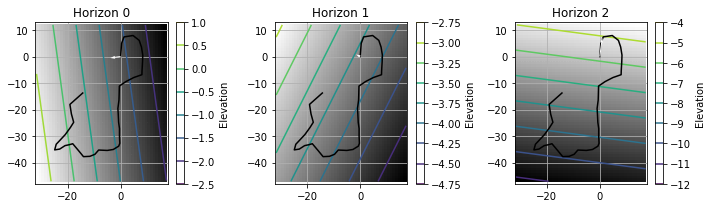

In [203]:
# imshow(arr_dem)



X,Y = generate_pixel_coordinates(arr_dem)
newX, newY = transform_pixel_coorindates(X,Y, rdem.meta["transform"], p_0)
pts = np.column_stack([newX.ravel(), newY.ravel()])
# XX, YY = X.ravel(), Y.ravel()
# T = rdem.meta["transform"]
# pts = np.column_stack([XX,YY])
# pts = np.array([np.array(T*p)  - p_0[:2] for p in pts])

# newX, newY = pts[:,0].reshape(X.shape),pts[:,1].reshape(X.shape)
figure(figsize=(10,3))
for h in hs:
    Z = np.array([evaluate_z(h.o, h.n, p) for p in pts]).reshape(X.shape)
    
    subplot(1,3,h.hid+1)
    
    grad = -np.array([h.n[0]/h.n[2], h.n[1]/h.n[2]]) # minus is needed as computed above
    h.gradient = grad # save for future use
    quiver(0, 0, grad[0], grad[1], zorder=1000, scale_units="inches", scale=0.400, color="white")
    
    pcolormesh(newX, newY,Z, cmap="gray")
    
    contour(newX,newY,Z)
    colorbar(label="Elevation")
    axis("equal")
    
    h.grid = [newX, newY , Z]
    
    title(f"Horizon {str(h.hid)}")
    plot(*path.T, color="black")
    grid()
    
tight_layout()
savefig(ff("mapview.png"), dpi=300)
show()

In [204]:
1

1

# Horizon's dips 

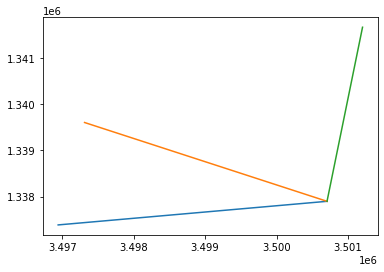

In [205]:
# we are curious to visualize the gradient in the sourrandig context, so we generate a suitable dataset
from shapely.geometry import LineString
figure()
origin = p_0[:2]
size = 3800 # m in the increasing direction

def generate_line_from_grad(origin, grad, size):
    g = grad / np.linalg.norm(grad)
    ps = origin 
    pe = origin + g*size # end point
    pts = np.row_stack([ps, pe])
    return pts

lines = []
for h in hs:
    pts = generate_line_from_grad(origin, h.gradient, size)
    line = LineString(pts)
    lines.append(line)
    plot(*pts.T) # also plot to have a look at them
    
asgpd = gpd.GeoDataFrame(geometry=lines)
asgpd.crs = rdem.meta["crs"]
asgpd.to_file(of("gradients.gpkg"), driver="GPKG")

# Unit's thicknesses in map view

In [206]:
units = [[hs[0], hs[1]], # top and bottom, for each unit (2 in this case)
         [hs[1], hs[2]]]

<ipython-input-207-2b67724b3c3e>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(t.grid[0],t.grid[1], thickness, cmap="gray")
<ipython-input-207-2b67724b3c3e>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(t.grid[0],t.grid[1], thickness, cmap="gray")


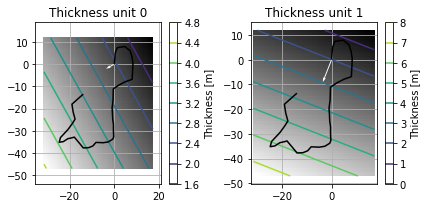

In [207]:
figure(figsize=(6,3))
lines = []
for i, (t, b) in enumerate(units):
    subplot(1,2,i+1)
    thickness = t.grid[2] - b.grid[2]
    pcolormesh(t.grid[0],t.grid[1], thickness, cmap="gray")
    
    contour(t.grid[0],t.grid[1], thickness)
    cbar = colorbar()
    cbar.set_label("Thickness [m]")
    
    thick_g = t.gradient - b.gradient
    quiver(0, 0, thick_g[0], thick_g[1], zorder=1000, scale_units="inches", scale=0.300, color="w")
    
    pts = generate_line_from_grad(origin, thick_g, size)
    line = LineString(pts)
    lines.append(line)
    title(f"Thickness unit {str(i)}")
    
    grid()
    plot(*path.T, color="black")
    
    axis("equal")
    tight_layout()
    
savefig(ff("thicknesses.png"), dpi=300)

In [208]:
asgpd = gpd.GeoDataFrame(geometry=lines)
asgpd.crs = rdem.meta["crs"]
asgpd.to_file(of("thickness_gradients.gpkg"), driver="GPKG")

# Predicting possible intersections in the crater

In [209]:
dem_f = "../rasters/NAC_DTM_CHANGE3.TIF"
dem =rasterio.open(dem_f)
from smalllib import crop_raster_rectangle

region= np.loadtxt(of("region.txt"))
region[0] -= 150 # move the right boundary to the right to include the crater
region[1] -=20
region[3] +=20

enlarged, new_meta = crop_raster_rectangle(dem, region[:2], region[2:], of("enlarged_dem.tif"))

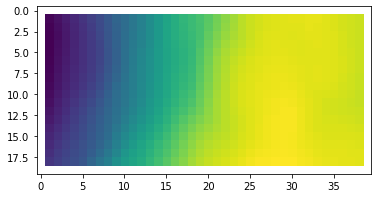

In [210]:
imshow(enlarged[0])

In [211]:

from smalllib import raster_to_pyvista_mesh

asmesh = raster_to_pyvista_mesh(enlarged[0], np.array(new_meta["transform"]).reshape(3,3))
asmesh.points -= p_0

In [212]:
bp.add_mesh(asmesh)

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0x7fef4c1d2ac0

In [213]:
for h in hs:
    vals = []
    for p in asmesh.points:
        v = p.dot(h.n) - h.o.dot(h.n) # distance of the point from the plane
        vals.append(v)
    asmesh.point_arrays[f"{h.hid}"] = vals

In [214]:
## asmesh.points

In [215]:
asmesh.save(of("meshing.vtp"))

In [216]:

from smalllib import save_as_obj

In [217]:
lines = []
for i in np.arange(3):
    l = asmesh.contour([0], scalars=str(i))
    lines.append(l)
    t = l.tube(radius=0.2)
    bp.add_mesh(l, color="red")
    
    t.points /= 1000
    save_as_obj(of(f"tube_{i}.obj"), t) # save for later in a good scale

In [218]:

from smalllib import extract_lines

In [219]:
outpts = []
for l in lines:
    slines = extract_lines(l)
    for subl in slines:
        outpts.append(l.points[subl])

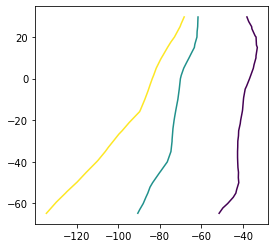

In [220]:
from shapely.geometry import LineString
lls= []
ids = []
for id, l in enumerate(outpts):
    lls.append(LineString(l))
    ids.append(id)
    
asgpd = gpd.GeoDataFrame(geometry=lls)
asgpd["hid"]= ids
asgpd.plot(column="hid")

asgpd.geometry= asgpd.translate(*p_0)

In [221]:
asgpd.crs = dem.meta["crs"]

In [222]:
asgpd.to_file(of("prediction.gpkg"), driver="GPKG")

# visualize some data 

In [223]:
base ="../rasters/NAC_DTM_CHANGE3_M1144922100_160CM.TIF"
basemap = rasterio.open(base)
from smalllib import crop_raster_rectangle, show_raster

cropped, meta = crop_raster_rectangle(basemap, region[:2], region[2:], of("cropped_ortho.tif"))

<ipython-input-224-ef8d60d315c4>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(Xt, Yt, cropped[0], cmap="gray")


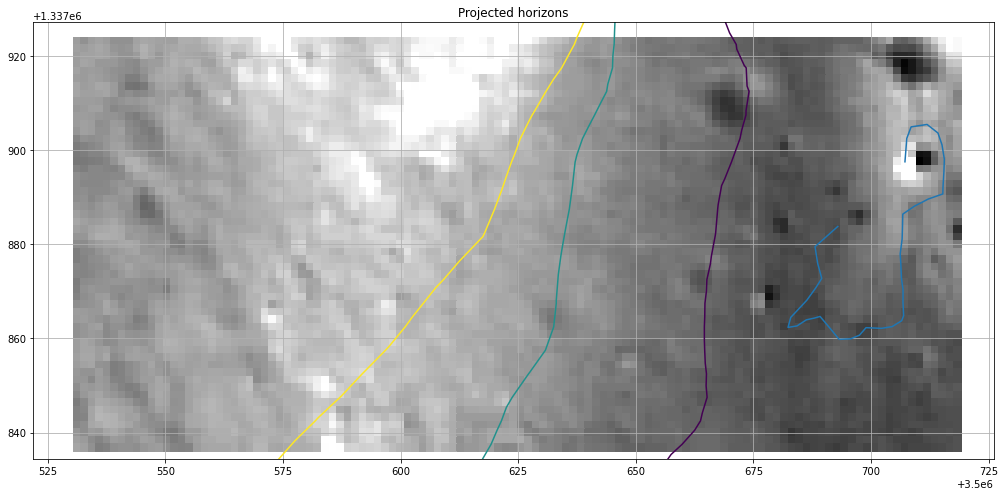

In [224]:

X,Y = generate_pixel_coordinates(cropped[0])
Xt, Yt = transform_pixel_coorindates(X,Y, meta["transform"])

figure(figsize=(14,7))



pcolormesh(Xt, Yt, cropped[0], cmap="gray")
asgpd.plot(ax=gca(), column="hid")
grid()
axis("equal")

pp = path + p_0[:2]
plot(*pp.T)
title("Projected horizons")


tight_layout()

savefig(ff("map-view.png"), dpi=300)

# At last we want to create a section
there might be several ways of doing so, we hereby show a good one for the specic case, which is also pretty generic

In [225]:
# we create the geometries to cut, namely the new planes
# everything is in the local ref frame

xmi, ymi, xma, yma = region # region was enlarged above, so we repeat this step
boundary_points = np.array([[xmi, ymi],
                            [xma, ymi],
                            [xma, yma],
                            [xmi, yma]]) - p_0[:2]

tocrop = [] # we put here everythin we need to section
for i, h in enumerate(hs):
    zz = [evaluate_z(h.o, h.n, p) for p in boundary_points]
    mm = pyvista.PolyData(np.column_stack([boundary_points, zz]), np.array([[4,0,1,2,3]]))
    bp.add_mesh(mm) # just to have an idea
    tocrop.append(mm)
    mm.points /=  1000
    save_as_obj(of(f"large_plane_{i}.obj"), mm)
    mm.points *=1000
    
tocrop.append(asmesh)

In [226]:
# define the plane to use for creating the section , in the local ref frame
# this is pretty generic so you could create any kind of cross section
normal = np.array([0,1,0])
o = np.array([0, -20, 0]) # 20 meters below the landing point

In [227]:
import vtk

In [228]:
def get_section(asmesh: vtk.vtkPolyData, normal, origin, return_untransformed=False):
    normal = normal / np.linalg.norm(normal)

    cutter = vtk.vtkCutter()
    plane = vtk.vtkPlane()
    plane.SetOrigin(origin)
    plane.SetNormal(normal)

    cutter.SetCutFunction(plane)
    cutter.SetInputData(asmesh)
    cutter.Update()

    cut = pyvista.PolyData(cutter.GetOutput())
    lines = extract_lines(cut)
    
    if return_untransformed:
        return [np.array(cut.points[l]) for l in lines]
    
    # we need to apply a transform to put the data in the local section reference frame
    # we start setting the new axis for building the transform
    z = -normal

    u = np.array([1,0,0.0]) # as x we will use the vector coming from projecting u onto the plane
    u = u / np.linalg.norm(u)
    x = u-u.dot(normal) * normal # note: we know they already are unit vectors

    y = np.cross(z,x) # third axis

    T = np.column_stack([x,y,z]) # note we know transform is orthonormal

    newpts = cut.points.dot(T)

    o = []
    
    for sline in lines:
        aa = newpts[:,:2][sline]
        o.append(np.array(aa))
        
    return o
    


In [229]:
out = []
for t in tocrop:
    out+= get_section(t, normal, o)
    


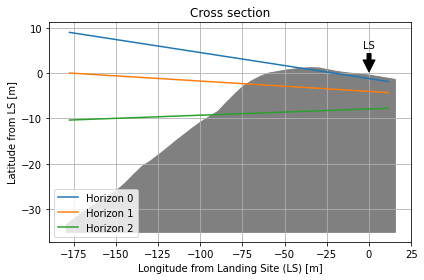

In [230]:
terrain = out[-1]
fill_between(terrain[:,0], np.ones(len(terrain))*-35, terrain[:,1], color="gray")

for i, h in enumerate(out[:-1]):
    plot(*h.T, label=f"Horizon {i}")
    
legend()

grid()

title("Cross section")
# annotate("LS", [0,0])

gca().annotate('LS',
            xy=(0,0), xycoords='data', 
            xytext=(0, 5), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='bottom')




gca().autoscale(1)
xlabel("Longitude from Landing Site (LS) [m]")
ylabel("Latitude from LS [m]")
tight_layout()
savefig(ff("section.png"), dpi=300)

In [231]:
newbounds = gpd.read_file("../images/crater_bounds.gpkg")
newbounds = newbounds.geometry[0]

base ="../rasters/NAC_DTM_CHANGE3_M1144922100_160CM.TIF"
basemap = rasterio.open(base)
from smalllib import crop_raster_rectangle

cropped2, meta = crop_raster_rectangle(basemap, newbounds.bounds[:2], newbounds.bounds[2:], of("cropped_ortho.tif"))

/home/luca/data/Code/yutu_radagram_3dmodelling.git/notebooks/smalllib.py:247: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(Xt, Yt, array,*args, **kwargs)


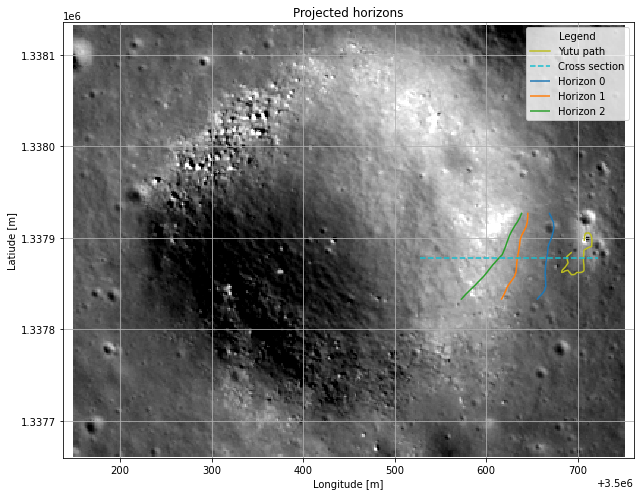

In [232]:

figure(figsize=(9,7))
show_raster(cropped2[0], meta, cmap="gray")

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in [0,1,2]:
    ex = asgpd[asgpd["hid"] == i]
    
    ex.plot(ax=gca(), label = f"Horizon {i}", color=palette[i])
grid()
axis("equal")

pp = path + p_0[:2]
plot(*pp.T, color=palette[-2], label="Yutu path")
title("Projected horizons")

# but we also draw the section line

sec_points = get_section(t, normal, o,True)
for p in sec_points:
    x,y = (p[:,:2] + p_0[:2]).T 
    plot(x,y, "--", label="Cross section", color=palette[-1])


legend(title="Legend")    

xlabel("Longitude [m]")
ylabel("Latiude [m]")

gca().autoscale()

tight_layout()



savefig(ff("map-view-section.png"), dpi=300)